In [7]:
import numpy as np
import math
import random
import pprint
import pygame
import sys
import matplotlib.pyplot as plt
#===========CHANGABLE PARAMETERS=================
REWARD     = 1
PENALTY    = -1
DISCOUNT   = 0.8
LEARN_RATE_CONST = 200

def get_explore_rate(epoch):
    return max(0.1,1-math.log2(epoch*10)/20)

#===========DEFINE CONSTANTS AND DICS=============
WALL_LEN = 1
PADDLE_H = 0.2

init_state = (0.5, 0.5, 0.03, 0.01, 0.5 - PADDLE_H / 2)

ACTION_DIC={0:-0.04, #'UP'
            1:0,     #'STAY'
            2:0.04}  #'DOWN'

BOARD_SIZE = 12
X_VBALL_DIS = [-1,1]
Y_VBALL_DIS = [-1,0,1]

PADDLE_SPACE = 12
PADDLE_X     = 1

STATE_SPACE = (BOARD_SIZE,BOARD_SIZE,len(X_VBALL_DIS),len(Y_VBALL_DIS),PADDLE_SPACE)

X_V_TSH = 0.03
Y_V_TSH = 0.015

#==============DEFINE STATE CLASS===============
class state:
    
    def __init__(self,ball_x,ball_y,velocity_x,velocity_y,paddle_y,reward,end_state = 0):
        self.ball_x = ball_x              #real numbers on the interval [0,1]
        self.ball_y = ball_y
        self.velocity_x = velocity_x
        self.velocity_y = velocity_y
        self.paddle_y = paddle_y
        self.reward = reward
        self.state_tuple = (ball_x,ball_y,velocity_x,velocity_y,paddle_y)
        self.end_state = end_state
        self._extract()
        
    def _extract(self):
        self.x_grid = min(math.floor(12*self.ball_x),BOARD_SIZE-1)
        self.y_grid = min(math.floor(12*self.ball_y),BOARD_SIZE-1)
        if(self.velocity_x>0): 
            self.x_v_sign = 0
        else: 
            self.x_v_sign = 1
            
        if(self.velocity_y>=0.015):
            self.y_v_sign = 0
        elif(self.velocity_y<=0.015): 
            self.y_v_sign = 1
        else:
            self.y_v_sign = 2
        self.paddle_grid = min(math.floor(12 * self.paddle_y / (1 - PADDLE_H)),PADDLE_SPACE-1)
        self.space_tuple = (self.x_grid,self.y_grid,self.x_v_sign,self.y_v_sign,self.paddle_grid)
        
#=============DEFINE Q-AGENT CLASS==============
class q_agent:
    
    def __init__(self,mode = 'new',learning = 'Q'):
        if mode == 'new':
            print('successfully generate a new Q-Agent!')
            self.q_table = np.zeros(STATE_SPACE+(len(ACTION_DIC),)) 
            self.table_vis = np.zeros(STATE_SPACE+(len(ACTION_DIC),))
            self.end_state = 0
        elif mode == 'load':
            print('loading past data...')
            if learning == 'Q':
                self.q_table = np.load('qtable.npy')
                self.table_vis = np.load('tablevis.npy')
            elif learning == 'SARSA':
                self.q_table = np.load('qtable_sa.npy')
                self.table_vis = np.load('tablevis_sa.npy')
            else:
                print('wrong learning method!')
                sys.exit()
            print('successfully load data')
        else:
            print('cannot read the mode, exit')
            sys.exit()
        
    def set_table(self,loc,val):
        self.q_table[loc] = val
    
    def get_table(self,loc):
        return self.q_table[loc]

    def get_c(self,loc):
        return self.table_vis[loc]
    
    def set_c(self,loc,val):
        self.table_vis[loc] = val
        
    def get_act(self,cur_state,i,mode = 'train',learning='Q'):
        if mode=='train' and random.random()<get_explore_rate(i):
            return random.choice(range(0,3,1))
        return np.argmax(self.get_table(cur_state.space_tuple))
    

#=======DEFINE MORE HELPER FUNCTIONS===========
def bounce(cur_state,action,mode = 'Part1.1'):
    n_ball_v_x = cur_state.velocity_x
    n_ball_v_y = cur_state.velocity_y

    n_ball_x = cur_state.ball_x + n_ball_v_x
    n_ball_y = cur_state.ball_y + n_ball_v_y

    fac = n_ball_v_y*(1-cur_state.ball_x)/n_ball_v_x #for 1.1
    cmp_y = cur_state.ball_y + fac
    
    fac_2 = n_ball_v_y*(cur_state.ball_x)/n_ball_v_x
    cmp_y_2 = cur_state.ball_y + fac_2
    #======paddle should in range(0,0.8)=====
    n_paddle_y = min(WALL_LEN-PADDLE_H,max(0,cur_state.paddle_y + action))
    
    c_reward = 0
    
    #==the ball is off the top of the screen==
    if n_ball_y < 0:
        n_ball_y = -n_ball_y
        n_ball_v_y = -n_ball_v_y
        
    #==the ball is off the bottom of the screen==
    if n_ball_y > 1:
        n_ball_y = 2*WALL_LEN-n_ball_y
        n_ball_v_y = -n_ball_v_y
    
    #==the ball is off the left edge of the screen== ###PART1.1
    if n_ball_x < 0 and mode == 'Part1.1':
        n_ball_x = -n_ball_x
        n_ball_v_x = -n_ball_v_x
    #== the ball bouncing off the paddle==
    if n_ball_x >= 1 and mode == 'Part1.1' and (n_paddle_y+PADDLE_H >= min(max(0,cmp_y),1) >= n_paddle_y):
        n_ball_x = 2*PADDLE_X - n_ball_x
        n_ball_v_x, n_ball_v_y = update_speed_rand(n_ball_v_x,n_ball_v_y)
        c_reward = REWARD
    elif n_ball_x > 1 and mode == 'Part1.1':
        c_reward = PENALTY
    
    #==the ball is off the left edge of the screen== ###PART1.2
    if n_ball_x > 1 and mode == 'Part1.2':
        n_ball_x = 2*WALL_LEN - n_ball_x
        n_ball_v_x = -n_ball_v_x
    #== the ball bouncing off the paddle==
    if n_ball_x <= 0 and mode == 'Part1.2' and (n_paddle_y+PADDLE_H >= min(max(0,cmp_y_2),1) >= n_paddle_y):
        n_ball_x = - n_ball_x
        n_ball_v_x, n_ball_v_y = update_speed_rand(n_ball_v_x,n_ball_v_y)
        c_reward = REWARD
    elif n_ball_x < 0 and mode == 'Part1.2':
        c_reward = PENALTY
   

    return n_ball_x,n_ball_y,n_ball_v_x,n_ball_v_y,n_paddle_y,c_reward

def update_speed_rand(velocity_x,velocity_y):
    vx_delta = random.choice(range(-1,2,2)) * random.choice(range(0,16,1)) / 1000
    vy_delta = random.choice(range(-1,2,2)) * random.choice(range(0,4,1))  / 100
    sign_x = -velocity_x/abs(velocity_x)
    sign_y = velocity_y/abs(velocity_y)
    n_ball_v_x = sign_x*max(X_V_TSH,min(1,abs(vx_delta+velocity_x)))
    n_ball_v_y = sign_y*max(Y_V_TSH,min(1,abs(vy_delta+velocity_y)))
    return n_ball_v_x, n_ball_v_y

def proceed_one_step(cur_state,action,mode = 'Part1.1'):

    n_ball_x,n_ball_y,n_ball_v_x,n_ball_v_y,n_paddle_y,c_reward = bounce(cur_state,action,mode)
    end = 0
    if c_reward == -1:
        end = 1
    n_state = state(n_ball_x,n_ball_y,n_ball_v_x,n_ball_v_y,n_paddle_y,c_reward,end_state=end)
    return n_state

#=============DEFINE TRAIN FUCNTION=============
def train(epoch_num,q_ag,mode = 'Part1.1',learning = 'Q'):
    graph = [0]
    pre_tot = 0
    tot_bounce = 0
    for i in range(1,epoch_num+1):
        temp_bounce = 0
        
        if mode == 'Part1.1':
            cur_state = state(0.5, 0.5, 0.03, 0.01, 0.5 - PADDLE_H / 2,0)
        elif mode == 'Part1.2':
            cur_state = state(0.5, 0.5, -0.03, 0.01, 0.5 - PADDLE_H / 2,0)
        sarsa_act = q_ag.get_act(cur_state,i)
        while True:

            if learning == 'Q':
                
                action = q_ag.get_act(cur_state,i)
                n_state = proceed_one_step(cur_state,ACTION_DIC[action],mode)
                old_val = q_ag.get_table(cur_state.space_tuple+(action,))


                prd_max = np.max(q_ag.get_table(n_state.space_tuple))
                prd_tuple = (n_state.x_grid,n_state.y_grid,n_state.x_v_sign,n_state.y_v_sign,n_state.paddle_grid,prd_max)

                Nsa = q_ag.get_c(cur_state.space_tuple+(action,))
                learn_rate = LEARN_RATE_CONST/(LEARN_RATE_CONST+Nsa)
                q_ag.set_c(cur_state.space_tuple+(action,),Nsa+1)

                new_val = (1-learn_rate)*old_val + learn_rate*(n_state.reward + DISCOUNT*prd_max)
                q_ag.set_table(cur_state.space_tuple+(action,),new_val)

                
                
            elif learning == 'SARSA':
                
                n_state = proceed_one_step(cur_state,ACTION_DIC[sarsa_act],mode)
                
                n_sarsa_act = q_ag.get_act(n_state,i)
                
                old_val = q_ag.get_table(cur_state.space_tuple+(sarsa_act,))


                prd_max = q_ag.get_table(n_state.space_tuple+(n_sarsa_act,))
#                 prd_tuple = (n_state.x_grid,n_state.y_grid,n_state.x_v_sign,n_state.y_v_sign,n_state.paddle_grid,prd_max)

                Nsa = q_ag.get_c(cur_state.space_tuple+(sarsa_act,))
                learn_rate = LEARN_RATE_CONST/(LEARN_RATE_CONST+Nsa)
                q_ag.set_c(cur_state.space_tuple+(sarsa_act,),Nsa+1)

                new_val = (1-learn_rate)*old_val + learn_rate*(n_state.reward + DISCOUNT*prd_max)
                q_ag.set_table(cur_state.space_tuple+(sarsa_act,),new_val)
                sarsa_act = n_sarsa_act
                
            else: 
                print('Wrong learning input!')
                sys.exit()    
                
            if n_state.end_state == 1:
                break
            if n_state.reward == REWARD:
                temp_bounce+=1
            cur_state = n_state
        tot_bounce+=temp_bounce
        if i%1000 == 0:
            print('loop',i)
            print('now average bounce in this 1000 round is', (tot_bounce-pre_tot)/1000)
            print('bounce=',tot_bounce-pre_tot)
            print()
            graph.append(tot_bounce/i)
            pre_tot = tot_bounce
    return graph
#================DEFINE TEST FUNCTION============
def test(epoch_num,q_ag,mode = 'Part1.1'):
    print('testing')
    tot_bounce = 0
    for i in range(epoch_num):
        temp_bounce = 0
        
        if mode == 'Part1.1':
            cur_state = state(0.5, 0.5, 0.03, 0.01, 0.5 - PADDLE_H / 2,0)
        elif mode == 'Part1.2':
            cur_state = state(0.5, 0.5, -0.03, 0.01, 0.5 - PADDLE_H / 2,0)
            
        while True:
            action = q_ag.get_act(cur_state,i,mode='hei')
            n_state = proceed_one_step(cur_state,ACTION_DIC[action],mode)
            if n_state.end_state == 1:
                break
            if n_state.reward == REWARD:
                temp_bounce+=1
            cur_state = n_state
        tot_bounce+=temp_bounce
    
    print('the avg bounce =',tot_bounce/epoch_num)

In [8]:
#=========================VISUALIZATION VERSION========================
WHITE = (255, 255, 255)
BLACK = (0,0,0)
BALL_COLOR = (255,186,186)
PAD_COLOR = (182, 209, 204)
BACKGROUND_COLOR = (255, 245, 222)
SCORE_COLOR = (25, 118, 210)

WIDTH = 600
HEIGHT = 600

BALL_RADIUS = 8
PAD_WIDTH = 8
PAD_HEIGHT = HEIGHT * 0.2
HALF_PAD_WIDTH = PAD_WIDTH // 2
HALF_PAD_HEIGHT = PAD_HEIGHT // 2
GAME_FPS = 30
GAME_END_FPS = 30

def draw(canvas, ball_x, ball_y, paddle_y, mode = 'Part1.1', player_x = 0, player_y = 0, player_pad = 0):
    canvas.fill(BACKGROUND_COLOR)
#     pygame.draw.line(canvas, WHITE, [WIDTH // 2, 0], [WIDTH // 2, HEIGHT], 1)
#     pygame.draw.line(canvas, WHITE, [PAD_WIDTH, 0], [PAD_WIDTH, HEIGHT], 1)
#     pygame.draw.line(canvas, WHITE, [WIDTH - PAD_WIDTH, 0], [WIDTH - PAD_WIDTH, HEIGHT], 1)

    if mode == 'Part1.1':
        paddle1_pos = (WIDTH + 1 - HALF_PAD_WIDTH, int(paddle_y * HEIGHT + HALF_PAD_HEIGHT))
        ball_pos = (int(ball_x * WIDTH) , int(ball_y * HEIGHT))

        pygame.draw.circle(canvas, BALL_COLOR, ball_pos, BALL_RADIUS, 0)
        pygame.draw.polygon(canvas, PAD_COLOR, [[paddle1_pos[0] - HALF_PAD_WIDTH, paddle1_pos[1] - HALF_PAD_HEIGHT],
                                            [paddle1_pos[0] - HALF_PAD_WIDTH, paddle1_pos[1] + HALF_PAD_HEIGHT],
                                            [paddle1_pos[0] + HALF_PAD_WIDTH, paddle1_pos[1] + HALF_PAD_HEIGHT],
                                            [paddle1_pos[0] + HALF_PAD_WIDTH, paddle1_pos[1] - HALF_PAD_HEIGHT]], 0)

    if mode == 'Part1.2':
        paddle1_pos = (0 - 1 + HALF_PAD_WIDTH, int(paddle_y * HEIGHT + HALF_PAD_HEIGHT))
        ball_pos = (int(ball_x * WIDTH) , int(ball_y * HEIGHT))

        pygame.draw.circle(canvas, BALL_COLOR, ball_pos, BALL_RADIUS, 0)
        pygame.draw.polygon(canvas, PAD_COLOR, [[paddle1_pos[0] - HALF_PAD_WIDTH, paddle1_pos[1] - HALF_PAD_HEIGHT],
                                            [paddle1_pos[0] - HALF_PAD_WIDTH, paddle1_pos[1] + HALF_PAD_HEIGHT],
                                            [paddle1_pos[0] + HALF_PAD_WIDTH, paddle1_pos[1] + HALF_PAD_HEIGHT],
                                            [paddle1_pos[0] + HALF_PAD_WIDTH, paddle1_pos[1] - HALF_PAD_HEIGHT]], 0)


def play(agent, epoches, mode = 'Part1.1'):
    
    pygame.init()
    fps = pygame.time.Clock()

    window = pygame.display.set_mode((WIDTH, HEIGHT))
    pygame.display.set_caption('Pong')


    
    rscore = 0

    for i in range(epoches):
        bounce = 0
        temp_bounce = 0
        if mode == 'Part1.1':
            cur_state = state(0.5, 0.5, 0.03, 0.01, 0.5 - PADDLE_H / 2,0)
        elif mode == 'Part1.2':
            cur_state = state(0.5, 0.5, -0.03, 0.01, 0.5 - PADDLE_H / 2,0)
        while True: 
            
            action = agent.get_act(cur_state,i,mode='hei')
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    sys.exit()
            
            
            n_state = proceed_one_step(cur_state,ACTION_DIC[action],mode)
            
            
            if n_state.end_state == 1:
                break
            
            draw(window, n_state.ball_x, n_state.ball_y, n_state.paddle_y,mode)
            
            pygame.display.update()
            fps.tick(GAME_FPS)
            cur_state = n_state
            bounce+=n_state.reward
        fps.tick(GAME_END_FPS)
        print(bounce)

    return

In [16]:
#======I'VE ALREAD TRAINED THE Q-AGENT SO JUST LOAD==========
q_td = q_agent('load','Q')
q_sa = q_agent('load','SARSA')

loading past data...
successfully load data
loading past data...
successfully load data


In [3]:
#======ELSE WE CAN DO THIS TO TRAIN==========================
q_td = q_agent()
# tsa = train(100000,q_sa,'Part1.1','Q')
# np.save('qtable_sa', q_sa.q_table)
# np.save('tablevis_sa', q_sa.table_vis)

# _1_2_sa = train(60000,q_sa,'Part1.2','SARSA')
ppopo = train(60000,q_td,'Part1.1','Q')

successfully generate a new Q-Agent!
loop 1000
now average bounce in this 1000 round is 1.037
bounce= 1037

loop 2000
now average bounce in this 1000 round is 1.413
bounce= 1413

loop 3000
now average bounce in this 1000 round is 1.572
bounce= 1572

loop 4000
now average bounce in this 1000 round is 1.685
bounce= 1685



KeyboardInterrupt: 

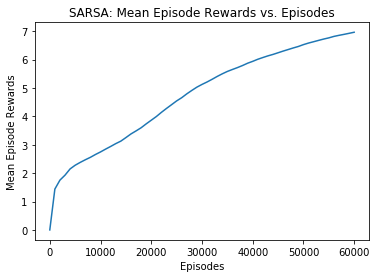

In [72]:
#========for 1.1====
plt.plot(list(range(0,len(t)*1000,1000)),t)
plt.ylabel('Mean Episode Rewards')
plt.xlabel('Episodes')
plt.title('SARSA: Mean Episode Rewards vs. Episodes')
plt.show()

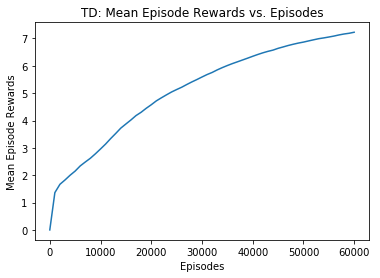

In [66]:
#=========for 1.1======
plt.plot(list(range(0,len(tq)*1000,1000)),tq)
plt.ylabel('Mean Episode Rewards')
plt.xlabel('Episodes')
plt.title('TD: Mean Episode Rewards vs. Episodes')
plt.show()

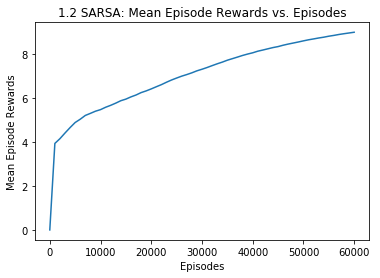

In [86]:
#===========for 1.2===
plt.plot(list(range(0,len(_1_2_sa)*1000,1000)),_1_2_sa)
plt.ylabel('Mean Episode Rewards')
plt.xlabel('Episodes')
plt.title('1.2 SARSA: Mean Episode Rewards vs. Episodes')
plt.show()

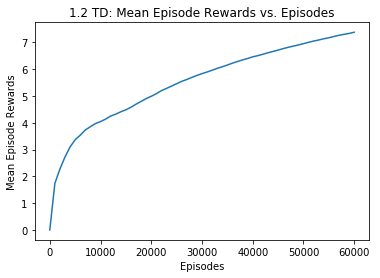

In [87]:
#==========for 1.2====
plt.plot(list(range(0,len(_1_2_td)*1000,1000)),_1_2_td)
plt.ylabel('Mean Episode Rewards')
plt.xlabel('Episodes')
plt.title('1.2 TD: Mean Episode Rewards vs. Episodes')
plt.show()

In [20]:
#======TEST WITHOUT VISUALIZATION============================
test(200,q_td,'Part1.1')

testing
the avg bounce = 14.515


In [ ]:
#========PLAY THE GAME!=======================================
play(q_td,200,'Part1.1')

16
6
15
4
4
7
7
10
21
5
32
20


In [2]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier

names = ['Ball-X','Ball-Y','Velocity-X','Velocity-Y','Paddle-Y','Action']
expert = pd.read_csv('../part2/expert_policy.txt', sep=" ", names=names)
x = expert.iloc[:,0:5]
y = expert.iloc[:,5:6]
mlp = MLPClassifier(hidden_layer_sizes=(256,256,256),max_iter=500,learning_rate_init=0.001,shuffle=True)
mlp.fit(x, y.values.ravel())
mlp.score(x,y)

0.8851

In [14]:
# makes prediction
# Parameters inside: ['Ball-X','Ball-Y','Velocity-X','Velocity-Y','Paddle-Y','Action']
mlp.predict([[0.6,0.6,0.03,0.01,0.9]])[0]

0.0

In [17]:
def test2(epoch_num,mlp):
    print('testing')
    tot_bounce = 0
    for i in range(epoch_num):
        temp_bounce = 0
        cur_state = state(0.5, 0.5, 0.03, 0.01, 0.5 - PADDLE_H / 2,0)
            
        while True:
            action = mlp.predict([list(cur_state.state_tuple)])[0]
            n_state = proceed_one_step(cur_state,ACTION_DIC[action])
            if n_state.end_state == 1:
                break
            if n_state.reward == REWARD:
                temp_bounce+=1
            cur_state = n_state
        tot_bounce+=temp_bounce
    
    print('the avg bounce =',tot_bounce/epoch_num)

In [9]:
cur_state = state(0.5, 0.5, 0.03, 0.01, 0.5 - PADDLE_H / 2,0)

In [22]:
test2(200,mlp)

testing
the avg bounce = 7.815
